In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

sns.set_style('whitegrid')

In [56]:

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from skopt import dummy_minimize
from skopt import gp_minimize
from skopt.plots import plot_convergence
# Corrige o alias np.int para evitar o erro
if not hasattr(np, 'int'):
    np.int = np.int64


import logging

# Configurar o logger para evitar mensagens de informação e advertência do LightGBM
logger = logging.getLogger('lightgbm')
logger.setLevel(logging.ERROR)  # ou logging.CRITICAL para ignorar todos os logs



In [57]:
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, precision_score, f1_score, roc_curve, log_loss, cohen_kappa_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline

In [58]:
from imblearn.over_sampling import SMOTE

![image](image/titanic.jpeg)

- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f
- https://docs.aws.amazon.com/pt_br/machine-learning/latest/dg/cross-validation.html

In [59]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_combine = pd.concat([df_train, df_test])#, axis = 1)

| Variable |      Definition      |       Key       |
|----------|:--------------------:|----------------:|
| survival |  Survival            | 0 = No, 1 = Yes |
| sex      |	Sex	| |
| Age |	Age in years	| |
| sibsp |	# of siblings / spouses aboard the Titanic	| |
| parch |	# of parents / children aboard the Titanic	| |
| ticket |	Ticket number	| |
| fare |	Passenger fare	| |
| cabin |	Cabin number	| |
| embarked |	Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton|

In [60]:
df_combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [61]:
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [62]:
df_combine.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [63]:
df_combine.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# Survived

In [64]:
print("% of who survived:", round(df_combine['Survived'].mean() * 100, 2), "%")
print("% of who not survived:",round((1 - df_combine['Survived'].mean()) * 100, 2), "%")

% of who survived: 38.38 %
% of who not survived: 61.62 %


### Class survived

In [65]:
df_combine[['Pclass', 'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


### Sex survived

In [66]:
df_combine[["Sex", "Survived"]].groupby(['Sex']).mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


### Sibling and Spouse  survived

In [67]:
df_combine[["SibSp", "Survived"]].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


## FamilySize 

In [68]:
df_combine[["Parch", "Survived"]].groupby(['Parch']).mean().sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000
9,NaN


In [69]:
df_combine['FamilySize'] = df_combine['SibSp'] + df_combine['Parch'] + 1

df_combine[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


###  Parent and Child survived

In [70]:
df_combine['IsAlone'] = 0
df_combine.loc[df_combine['FamilySize'] == 1, 'IsAlone'] = 1

df_combine[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


### Filter Embarked


In [71]:
# Calcula o porto mais frequente
freq_port = df_combine['Embarked'].dropna().mode()[0]

# Preenche NaNs com o porto mais frequente
df_combine['Embarked'] = df_combine['Embarked'].fillna(freq_port)

# Seu código original
df_combine[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Conclusion
Only 38% survived the crash. In this way we must look for correlations between the items we have. Analyze by pivoting features:
- **Sex:** Women make up 35% of the crew. Even with a smaller presence, 74% of them survived;
- **Pclass:** There is a correlation between the survivors, with the classification of their cabins;
- **SibSp and Parch:** These features have zero correlation. It will be necessary to change the data

## Plot for Age

<Figure size 2000x1000 with 0 Axes>

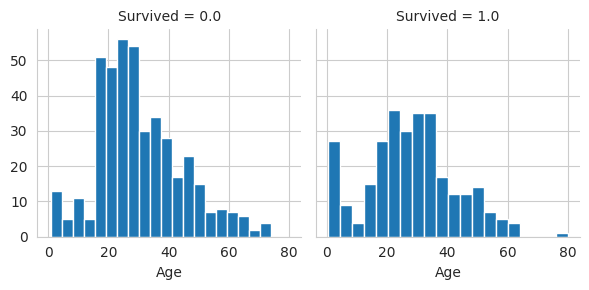

In [72]:
plt.figure(figsize=(20,10))
g = sns.FacetGrid(df_combine, col='Survived')
g.map(plt.hist, 'Age', bins=20)


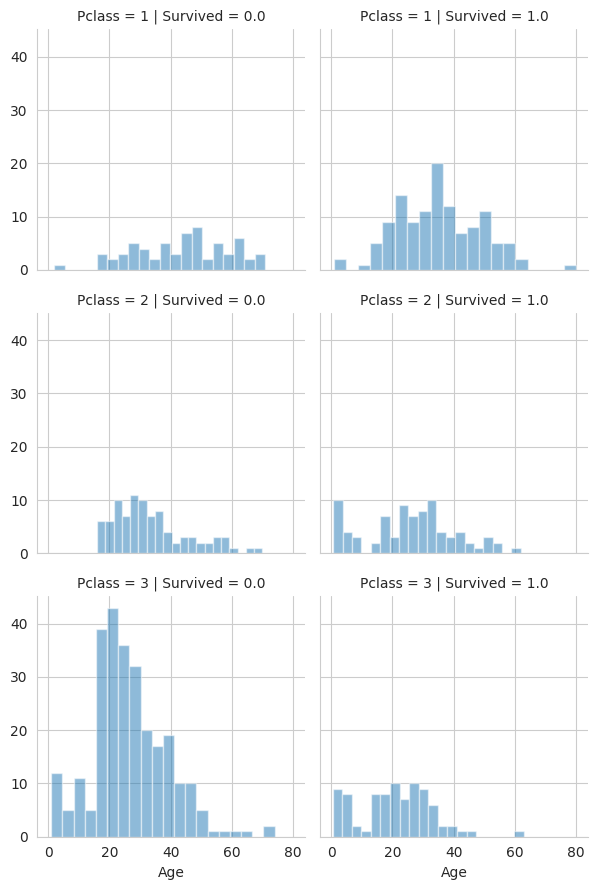

In [73]:
grid = sns.FacetGrid(df_combine, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

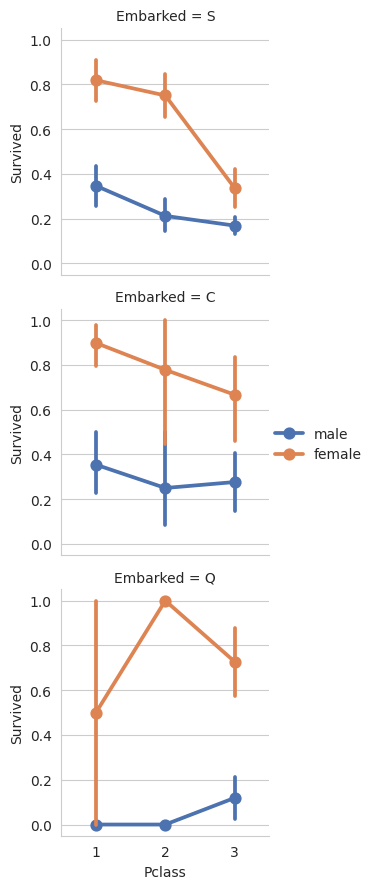

In [74]:
# Determine a order and hue_order based on your data
pclass_order = sorted(df_combine['Pclass'].unique())
sex_order = ['male', 'female']  # or ['female', 'male'], dependendo da sua preferência

grid = sns.FacetGrid(df_combine, row='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=pclass_order, hue_order=sex_order)
grid.add_legend()

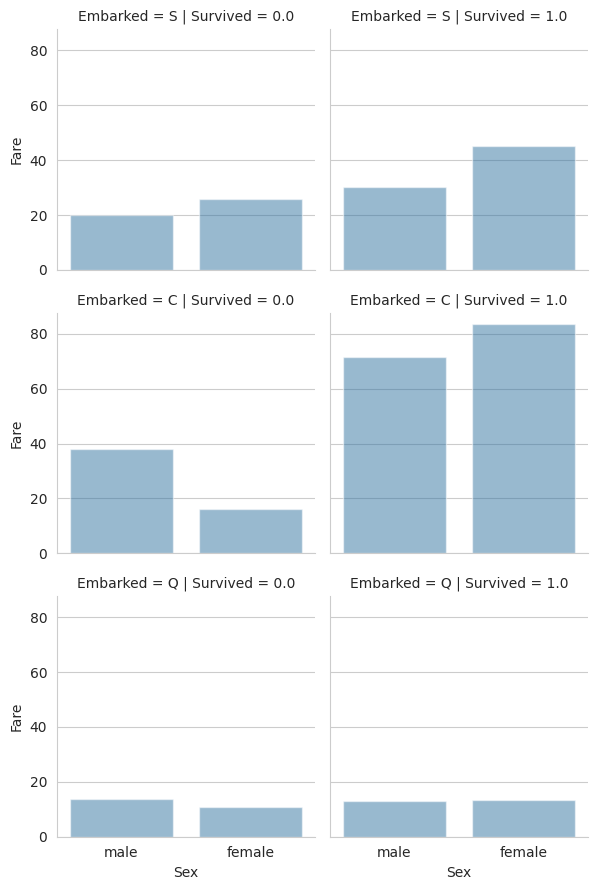

In [75]:
# Determine the order based on your data
sex_order = ['male', 'female']  # Ou ['female', 'male'], dependendo da sua preferência

grid = sns.FacetGrid(df_combine, row='Embarked', col='Survived')
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, errorbar=None, order=sex_order)
grid.add_legend()

## Filter Title

In [76]:
df_combine['Title'] = df_combine['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
df_combine['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [77]:
df_combine['Title'].value_counts()

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [78]:
df_combine['Title'] = [n if n in ["Mr", "Miss", "Mrs", "Master"] else 'Person' for n in df_combine['Title']]
df_combine['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Person'], dtype=object)

In [79]:
df_combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr


### Filter Age

In [80]:
df_combine['Age'].fillna(df_combine['Age'].median(), inplace=True)
df_combine['AgeBand'] = pd.cut(df_combine['Age'], 5)
df_combine[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False, observed=True).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.0902, 16.136]",0.550000
1,"(16.136, 32.102]",0.344168
2,"(32.102, 48.068]",0.404255
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [81]:
df_combine.loc[ df_combine['Age'] <= 16, 'Categori_Age'] = 0
df_combine.loc[(df_combine['Age'] > 16) & (df_combine['Age'] <= 32), 'Categori_Age'] = 1
df_combine.loc[(df_combine['Age'] > 32) & (df_combine['Age'] <= 48), 'Categori_Age'] = 2
df_combine.loc[(df_combine['Age'] > 48) & (df_combine['Age'] <= 64), 'Categori_Age'] = 3
df_combine.loc[(df_combine['Age'] >= 64), 'Categori_Age'] = 4

In [82]:
df_combine['Categori_Age'].value_counts()

Categori_Age
1.0    787
2.0    269
0.0    134
3.0    101
4.0     18
Name: count, dtype: int64

In [83]:
df_combine['Age*Class'] = df_combine.Categori_Age * df_combine.Pclass
df_combine.loc[:, ['Age*Class', 'Categori_Age', 'Pclass']].head(10)

,Age*Class,Categori_Age,Pclass
0,3.0,1.0,3
1,2.0,2.0,1
2,3.0,1.0,3
3,2.0,2.0,1
4,6.0,2.0,3
5,3.0,1.0,3
6,3.0,3.0,1
7,0.0,0.0,3
8,3.0,1.0,3
9,0.0,0.0,2


In [84]:
df_combine['FareBand'] = pd.qcut(df_combine['Fare'], 4)
df_combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False, observed=True).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197309
1,"(7.896, 14.454]",0.303571
2,"(14.454, 31.275]",0.441048
3,"(31.275, 512.329]",0.600000


In [85]:
# 1. Preenchendo NaNs
df_combine['Fare'].fillna(df_combine['Fare'].median(), inplace=True)

# 2. Verificando valores infinitos (opcional, mas uma boa prática)
if not np.isfinite(df_combine['Fare']).all():
    # Trate os valores infinitos como você achar melhor. Aqui, estou substituindo-os pela mediana
    median_fare = df_combine['Fare'].median()
    df_combine['Fare'] = df_combine['Fare'].replace([np.inf, -np.inf], median_fare)

# 3. Execute seu código original
df_combine.loc[ df_combine['Fare'] <= 7.91, 'Fare'] = 0
df_combine.loc[(df_combine['Fare'] > 7.91) & (df_combine['Fare'] <= 14.454), 'Fare'] = 1
df_combine.loc[(df_combine['Fare'] > 14.454) & (df_combine['Fare'] <= 31), 'Fare']   = 2
df_combine.loc[ df_combine['Fare'] > 31, 'Fare'] = 3
df_combine['Fare'] = df_combine['Fare'].astype(int)

df_combine = df_combine.drop(['FareBand'], axis=1)

df_combine.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,AgeBand,Categori_Age,Age*Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0,NaN,S,2,0,Mr,"(16.136, 32.102]",1.0,3.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,3,C85,C,2,0,Mrs,"(32.102, 48.068]",2.0,2.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,1,NaN,S,1,1,Miss,"(16.136, 32.102]",1.0,3.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3,C123,S,2,0,Mrs,"(32.102, 48.068]",2.0,2.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,1,NaN,S,1,1,Mr,"(32.102, 48.068]",2.0,6.0
5,6,0.0,3,"Moran, Mr. James",male,28.0,0,0,330877,1,NaN,Q,1,1,Mr,"(16.136, 32.102]",1.0,3.0
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,3,E46,S,1,1,Mr,"(48.068, 64.034]",3.0,3.0
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,2,NaN,S,5,0,Master,"(0.0902, 16.136]",0.0,0.0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,1,NaN,S,3,0,Mrs,"(16.136, 32.102]",1.0,3.0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,2,NaN,C,2,0,Mrs,"(0.0902, 16.136]",0.0,0.0


### Construct Data test and training

In [86]:
# pclass = pd.get_dummies(df_combine['Pclass'], prefix = 'Pclass', drop_first=True)
# title = pd.get_dummies(df_combine['Title'], prefix = 'Title', drop_first=True)
# sex = pd.get_dummies(df_combine['Sex'], prefix = 'Sex', drop_first=True)
# age = pd.get_dummies(df_combine['Age'], prefix = 'Age', drop_first=True)
# fare = pd.get_dummies(df_combine['Fare'], prefix = 'Fare', drop_first=True)
# embarked = pd.get_dummies(df_combine['Embarked'], prefix = 'Embarked', drop_first=True)
# age_class = pd.get_dummies(df_combine['Age*Class'], prefix = 'Age*Class', drop_first=True)
# df_concat = pd.concat([df_combine['Survived'], 
#                        pclass, 
#                        title, 
#                        sex, 
#                        age, 
#                        fare, 
#                        embarked, 
#                        age_class], axis=1)

In [87]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Columns to be encoded
columns_to_encode = ['Pclass', 'Title', 'Sex', 'Categori_Age', 'Fare', 'Embarked', 'Age*Class']

# Create a DataFrame with the selected columns
df_selected = df_combine[columns_to_encode]

# Apply OneHotEncoder to the selected columns
df_encoded = pd.DataFrame()
for column in columns_to_encode:
    encoded_data = encoder.fit_transform(df_selected[[column]])
    column_names = encoder.get_feature_names_out([column])
    df_encoded = pd.concat([df_encoded, pd.DataFrame(encoded_data, columns=column_names)], axis=1)

# Reset the index of df_combine
df_combine_reset = df_combine.reset_index(drop=True)

# Concatenate the encoded DataFrame with the original DataFrame
df_concat = pd.concat([df_combine_reset['Survived'], df_encoded], axis=1)

In [88]:
df_concat.columns

Index(['Survived', 'Pclass_2', 'Pclass_3', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Person', 'Sex_male', 'Categori_Age_1.0',
       'Categori_Age_2.0', 'Categori_Age_3.0', 'Categori_Age_4.0', 'Fare_1',
       'Fare_2', 'Fare_3', 'Embarked_Q', 'Embarked_S', 'Age*Class_1.0',
       'Age*Class_2.0', 'Age*Class_3.0', 'Age*Class_4.0', 'Age*Class_6.0',
       'Age*Class_8.0', 'Age*Class_9.0', 'Age*Class_12.0'],
      dtype='object')

In [89]:
train = df_concat[:len(df_train)].copy()
test = df_concat[(len(df_combine) - len(df_test)):].copy()
df_concat.shape, train.shape, test.shape

((1309, 25), (891, 25), (418, 25))

In [90]:
X_train = train.drop('Survived', axis = 1)
y_train = train['Survived'] 
X_test = test.drop("Survived", axis=1).copy()
# y_test
X_train.shape, y_train.shape, X_test.shape

((891, 24), (891,), (418, 24))

In [91]:
# def benchmark_ml(algorithms, X_train, y_train, cross_validation):
#     benchmark_ml = []

#     for algorithm_name, algorithm in algorithms.items():
#         # print(algorithm_name, algorithm)
#         model = algorithm.fit(X_train, y_train)
#         accuracy = round(model.score(X_train, y_train) * 100, 2)
        
#         train_predict = cross_val_predict(algorithm, X_train, y_train, cv= cross_validation, n_jobs = -1)
#         accuracy_cross_validation = round(accuracy_score(y_train, train_predict) * 100, 2)
#         recall_score_cross_validation = round(recall_score(y_train, train_predict) * 100, 2)
#         precision_score_cross_validation = round(precision_score(y_train, train_predict) * 100, 2)
#         f1_score_cross_validation = round(f1_score(y_train, train_predict) * 100, 2)
        
#         # confusion_matrix_cross_validation = confusion_matrix(y_train, train_predict)
#         # roc_curve_cross_validation = roc_curve(y_train, train_predict)
        
#         benchmark_ml.append({'algorithm': algorithm_name,
#                              'accuracy (%)': accuracy,
#                              'accuracy_cross_validation (%)': accuracy_cross_validation,
#                              'recall_score' : recall_score_cross_validation,
#                              'precision_score' : precision_score_cross_validation,
#                              'f1_score' : f1_score_cross_validation,
#                             #  'confusion_matrix' : confusion_matrix_cross_validation,
#                             #  'roc_curve' : roc_curve_cross_validation,
                             
#                              })
#     df_benchmark = pd.DataFrame(benchmark_ml)
#     return df_benchmark.sort_values('accuracy_cross_validation (%)', ascending=False)

In [92]:
algorithms = {'Logistic Regression' : LogisticRegression(max_iter = 1000, random_state=42),
              'Decision Tree' : DecisionTreeClassifier(random_state=42),
              'SVM' : SVC(random_state=42, probability=True),
              'NuSVC' : NuSVC(random_state=42, probability=True),
              # 'LinearSVC' : LinearSVC(dual = False, random_state=42),
              'GaussianNB' : GaussianNB(),
              'MultinomialNB' : MultinomialNB(),
              'ComplementNB' : ComplementNB(),
              # 'KNeighborsClassifier' : KNeighborsClassifier(n_clusters=3, n_init=1000),
            #   'KMeans' : KMeans(),
              'Random Forest' : RandomForestClassifier(n_estimators=100, random_state=42),
              'GradientBoostingClassifier' : GradientBoostingClassifier(random_state=42),
              'XGBoost' : XGBClassifier(random_state=42 , n_jobs = -1),
              'CatBoostClassifier' : CatBoostClassifier(random_state=42, verbose=False, save_snapshot=False),
              # 'LGBMClassifier' : LGBMClassifier(random_state=42, n_jobs=-1),
              # 'Stochastic Gradient Decent' : SGDClassifier(random_state=42), 
              # 'Perceptron' : Perceptron(random_state=42),
              # 'Linear Regression' : LinearRegression(),
              }

In [93]:
# result = benchmark_ml(algorithms, X_train, y_train, cross_validation = 10)
# result

In [94]:
# params = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5],
#     'min_child_weight': [1, 2, 3],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
# }
# cross_validation = 5

In [95]:
# best_algorithm = algorithms[result.iloc[0]['algorithm']]
# # best_algorithm = GradientBoostingClassifier()

# cross_validation = GridSearchCV(estimator = best_algorithm, param_grid = params, cv = cross_validation, n_jobs = -1)

In [96]:
# cross_validation.fit(X_train, y_train)

# # accuracy         
# round(cross_validation.best_score_ * 100, 4)

In [97]:
# # #best parameters
# cross_validation.best_estimator_

In [98]:
# best_algorithm_predict = cross_validation.predict(X_test)
# solution = pd.DataFrame({'PassengerId' : df_test['PassengerId'], 
#                          'Survived' : best_algorithm_predict.astype(int)})

# solution.to_csv('data/predict/test.csv', index = False)

---


In [99]:
def cross_validation(algorithms, X, y, n_splits, seed_number, oversampling = False):
    
    cv = KFold(n_splits=n_splits, random_state=seed_number, shuffle=True)
    
    metrics_split = []
    
    second_level = np.zeros((X.shape[0], len(algorithms)))
    
    for index_algorithm, (algorithm_name, algorithm) in enumerate(algorithms.items()):
        # print(f'{algorithm_name}')

        f1_score_cross_validation = []
        log_loss_cross_validation = []
        kappa_cross_validation = []
        roc_auc_score_cross_validation = []
        average_precision_validation = []
        
        predictions_matrix = np.zeros((X.shape[0], n_splits))
        
        for index_split, (index_train, index_validation) in enumerate(cv.split(X, y)):
            
            X_train, X_validation = X.iloc[index_train, :], X.iloc[index_validation, :]
            y_train, y_validation =  y.loc[index_train], y.loc[index_validation]
            
            if oversampling:
                smote = SMOTE(random_state = seed_number)
                X_train, y_train = smote.fit_resample(X_train, y_train)
        
            train_predict = algorithm.fit(X_train, y_train.values.flatten())
            predict_validation = algorithm.predict_proba(X_validation)[:,1]
            predict_validation_ = (predict_validation > 0.5).astype(int)
        

            f1_score_cross_validation.append(f1_score(y_validation, predict_validation_))
            log_loss_cross_validation.append(log_loss(y_validation, predict_validation))
            kappa_cross_validation.append(cohen_kappa_score(y_validation, predict_validation_))
            roc_auc_score_cross_validation.append(roc_auc_score(y_validation, predict_validation_))
            average_precision_validation.append(average_precision_score(y_validation, predict_validation_))
            # print(f'Split accuracy {algorithm_name}: {accuracy_cross_validation}')
            predictions_matrix[index_validation, index_split] = predict_validation

        second_level[:, index_algorithm] = np.mean(predictions_matrix, axis=1)
        # print(predictions_matrix.shape, second_level.shape)
        metrics_split.append({'algorithm': algorithm_name,
                              'log_loss' : round(np.mean(log_loss_cross_validation) * 100, 2),
                              'kappa' : round(np.mean(kappa_cross_validation) * 100, 2),
                              'roc_auc' : round(np.mean(roc_auc_score_cross_validation) * 100, 2),
                              'average_precision' : round(np.mean(average_precision_validation) * 100, 2),
                              'f1_score' : round(np.mean(f1_score_cross_validation) * 100, 2),

                              })
    metrics_split = pd.DataFrame(metrics_split)
    return metrics_split.sort_values('log_loss', ascending=True), second_level, cv

In [100]:
n_splits = 5
seed_number = 42

In [101]:
accuracy_without_oversampling, second_level, cv = cross_validation(algorithms, X_train, y_train, n_splits, seed_number)
accuracy_without_oversampling

,algorithm,log_loss,kappa,roc_auc,average_precision,f1_score
10,CatBoostClassifier,42.27,62.09,80.09,69.08,75.20
8,GradientBoostingClassifier,42.44,60.26,79.08,68.05,73.80
2,SVM,43.17,62.48,80.02,69.94,75.00
0,Logistic Regression,44.27,58.10,78.77,65.37,73.56
3,NuSVC,44.96,58.17,78.20,66.41,72.65
9,XGBoost,45.86,61.42,79.99,68.20,75.13
5,MultinomialNB,49.44,53.90,76.78,62.52,71.06
6,ComplementNB,50.66,51.89,76.62,60.51,71.38
7,Random Forest,80.43,62.13,80.37,68.78,75.54
1,Decision Tree,188.44,59.92,79.08,67.44,73.85


In [102]:
accuracy_oversampling, second_level, cv  = cross_validation(algorithms, X_train, y_train, n_splits, seed_number, oversampling = True)
accuracy_oversampling

,algorithm,log_loss,kappa,roc_auc,average_precision,f1_score
8,GradientBoostingClassifier,42.89,61.19,80.23,67.60,75.49
10,CatBoostClassifier,43.25,61.67,80.66,67.67,76.08
2,SVM,44.88,58.99,79.50,65.60,74.57
0,Logistic Regression,45.91,55.83,78.44,63.07,73.51
9,XGBoost,46.57,62.49,80.99,68.31,76.45
3,NuSVC,46.98,58.39,79.60,64.77,74.84
5,MultinomialNB,50.92,52.74,76.99,61.07,71.86
6,ComplementNB,50.92,52.74,76.99,61.07,71.86
7,Random Forest,88.21,61.60,80.61,67.62,75.98
1,Decision Tree,193.53,60.67,79.98,67.16,75.15


In [103]:
def boost_LGBMClassifier(params):
    model = LGBMClassifier(learning_rate=params[0], 
                         num_leaves=int(params[1]), 
                         min_child_samples=int(params[2]),
                         subsample=params[3],
                         colsample_bytree=params[4], 
                         random_state=42, 
                         subsample_freq=1, 
                         n_estimators=200)  # Aumentei o número de estimadores
    model.fit(X_train, y_train)
    p = model.predict_proba(X_train)[:, 1]

    return -roc_auc_score(y_train, p) 

# Ajuste os intervalos e adicione mais opções ao espaço de busca
space_LGBMClassifier = [
    (1e-4, 1e-1, 'log-uniform'),  # learning_rate
    (2, 256),  # num_leaves
    (1, 200),  # min_child_samples
    (0.5, 1.0),  # subsample
    (0.5, 1.0)  # colsample_bytree
]

In [104]:
# Função objetivo para otimização
def boost_catboostclassifier(params):
    model = CatBoostClassifier(
        iterations=int(params[0]),
        learning_rate=params[1],
        depth=int(params[2]),
        colsample_bylevel=params[3],
        subsample=params[4],
        min_child_samples=int(params[5]),
        max_bin=int(params[6]),
        random_state=42,
        verbose=0
    )
    model.fit(X_train, y_train)
    p = model.predict_proba(X_train)[:, 1]

    return -roc_auc_score(y_train, p)  # Otimização procura minimizar a função, então negamos a pontuação de validação cruzada
space_catboostclassifier = [
    (10, 500), # iterations
    (0.001, 0.3), # learning_rate
    (2, 16), # depth
    (0.1, 1.0), # colsample_bylevel
    (0.1, 1.0), # subsample
    (1, 10), # min_child_samples
    (1, 50) # max_bin
]



In [105]:
# Função objetivo para otimização
def boost_GradientBoostingClassifier(params):
    model = GradientBoostingClassifier(
        learning_rate=params[0],
        n_estimators=params[1],
        max_depth=params[2],
        min_samples_split=params[3],
        min_samples_leaf=params[4],
        subsample=params[5],
        random_state=42
    )
    model.fit(X_train, y_train)
    p = model.predict_proba(X_train)[:, 1]

    return -roc_auc_score(y_train, p)  # Otimização procura minimizar a função, então negamos a pontuação de validação cruzada


space_GradientBoostingClassifier = [
    (1e-4, 1e-1, 'log-uniform'),  # learning_rate
    (50, 200),                    # n_estimators
    (3, 10),                      # max_depth
    (2, 10),                      # min_samples_split
    (1, 10),                      # min_samples_leaf
    (0.5, 1.0, 'uniform')         # subsample
]



In [135]:
# Função objetivo para otimização
def boost_XGBClassifier(params):
    model = XGBClassifier(
        learning_rate=params[0],
        n_estimators=params[1],
        max_depth=int(params[2]),
        min_child_weight=int(params[3]),
        subsample=params[4],
        colsample_bytree=params[5],
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    p = model.predict_proba(X_train)[:, 1]

    return -roc_auc_score(y_train, p)

# Espaço de busca para XGBClassifier
space_XGBClassifier = [
    (1e-4, 1e-1, 'log-uniform'),  # learning_rate
    (50, 200),                     # n_estimators
    (1, 10),                       # max_depth
    (1, 10),                       # min_child_weight
    (0.5, 1.0, 'uniform'),         # subsample
    (0.5, 1.0, 'uniform')          # colsample_bytree
]

In [136]:
n_calls = 30
random_state = 42
n_random_starts = 10

# Random search - busca aleatória

In [137]:
result_dummy_XGBClassifier = dummy_minimize(boost_XGBClassifier, space_XGBClassifier, random_state=random_state, n_calls=n_calls)

In [107]:
# Execute a otimização de hiperparâmetros usando dummy_minimize
result_dummy_LGBMClassifier = dummy_minimize(boost_LGBMClassifier, space_LGBMClassifier, random_state=random_state, n_calls=n_calls)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [108]:
result_dummy_catboostclassifier = dummy_minimize(boost_catboostclassifier, space_catboostclassifier, n_calls=n_calls, random_state=random_state)

In [109]:
result_dummy_GradientBoostingClassifier = dummy_minimize(boost_GradientBoostingClassifier, space_GradientBoostingClassifier, n_calls=n_calls, random_state=random_state)

In [ ]:
# result_dummy_GradientBoostingClassifier.x

# Bayesian Optimization

In [139]:
result_gp_XGBClassifier = gp_minimize(boost_XGBClassifier, space_XGBClassifier, random_state=random_state, n_calls=n_calls, n_random_starts=n_random_starts)

/home/rvanguita/git/DataScientists/.venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



In [110]:
# Execute a otimização de hiperparâmetros usando dummy_minimize
result_gp_LGBMClassifier = gp_minimize(boost_LGBMClassifier, space_LGBMClassifier, random_state=random_state, n_calls=n_calls, n_random_starts=n_random_starts)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [111]:
result_gp_catboostclassifier  = gp_minimize(boost_catboostclassifier, space_catboostclassifier, random_state=random_state, n_calls=n_calls, n_random_starts=n_random_starts)

In [112]:
result_gp_GradientBoostingClassifier  = gp_minimize(boost_GradientBoostingClassifier, space_GradientBoostingClassifier, random_state=random_state, n_calls=n_calls, n_random_starts=10)

In [113]:
# result_gp_GradientBoostingClassifier.x

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


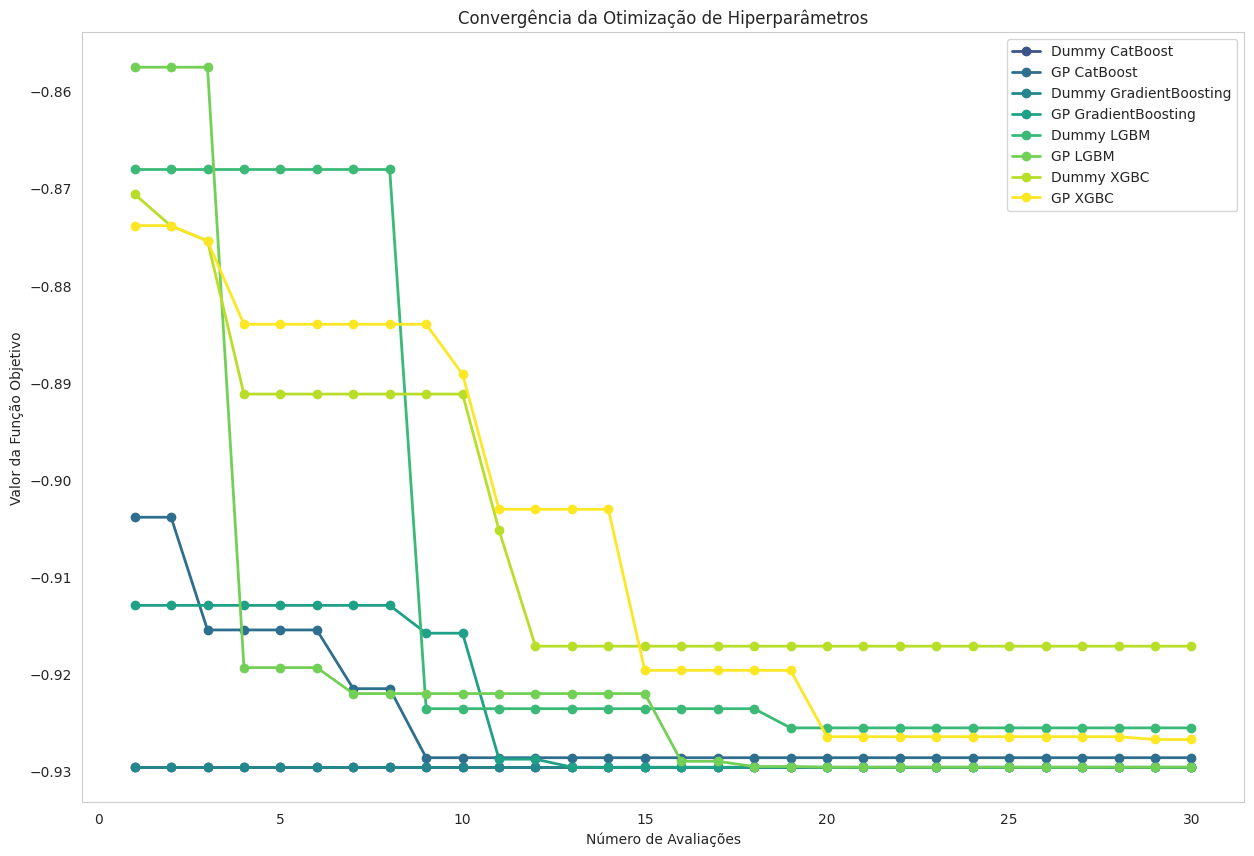

In [142]:
# Crie os gráficos de convergência individualmente
fig, ax = plt.subplots(figsize=(15, 10))
plot_convergence(result_dummy_catboostclassifier, 
                 result_dummy_GradientBoostingClassifier, 
                 result_gp_catboostclassifier,
                 result_gp_GradientBoostingClassifier,
                 result_dummy_LGBMClassifier,
                 result_gp_LGBMClassifier,
                 result_dummy_XGBClassifier,
                 result_gp_XGBClassifier
                 
                 )
# Adicione a legenda
ax.legend()

# Adicione rótulos e título se necessário
ax.set_xlabel('Número de Avaliações')
ax.set_ylabel('Valor da Função Objetivo')
plt.title('Convergência da Otimização de Hiperparâmetros')

# Adicione a legenda
ax.legend(['Dummy CatBoost', 'GP CatBoost', 'Dummy GradientBoosting', 'GP GradientBoosting', 'Dummy LGBM', 'GP LGBM', 'Dummy XGBC', 'GP XGBC'])

# Adicione rótulos e título se necessário
ax.set_xlabel('Número de Avaliações')
ax.set_ylabel('Valor da Função Objetivo')
plt.title('Convergência da Otimização de Hiperparâmetros')

# Exiba o gráfico
plt.show()

In [144]:
# params = result_dummy.x
params = result_gp_catboostclassifier.x

In [173]:
model = CatBoostClassifier(iterations=params[0],
                            learning_rate=params[1],
                            depth=params[2],
                            colsample_bylevel=params[3],
                            subsample=params[4],
                            min_child_samples=params[5],
                            max_bin=params[6],
                            random_state=42,
                            verbose=0
                            )
n_splits = 10

In [230]:
def final_ml(X, X_test, y, n_splits, model):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Inicialize uma lista para armazenar as pontuações de cada fold
    scores = []

    predictions_matrix = {}
    # Loop sobre os folds
    for index_split, (index_train, index_validation) in enumerate(cv.split(X, y)):
        # Divida os dados em conjuntos de treino e teste
        X_train, X_validation = X.iloc[index_train, :], X.iloc[index_validation, :]
        y_train, y_validation =  y.loc[index_train], y.loc[index_validation]

        # Treine o modelo no conjunto de treino
        model.fit(X_train, y_train)

        predict_validation = model.predict_proba(X_test)[:, 1]

        predictions_matrix[index_split] = predict_validation    

    # Calcule a média para cada posição nos arrays
    media_por_posicao = np.mean(list(predictions_matrix.values()), axis=0)
    
    # Exiba a previsão final
    # print("Previsão final no conjunto de dados completo:", final_predictions_on_full_data)
    return scores, media_por_posicao

In [231]:
scores, final_predictions = final_ml(X_train, X_test, y_train, n_splits, model)

In [239]:
predict_validation_ = (final_predictions > 0.79).astype(int)
solution = pd.DataFrame({'PassengerId' : df_test['PassengerId'], 
                         'Survived' : predict_validation_.astype(int)})

solution.to_csv('data/predict/test.csv', index = False)

---

# Stacking

In [117]:
# def ensemble_stacking(cv, algorithm, second_level, X_test, X_train, y_train):

#     algorithm_state = 0
    
#     for algorithm_name, algorithm in algorithm.items():
#         for index_test, index_validation in cv.split(X_test):

#             X_train, X_validation = second_level[index_test], second_level[index_validation]
#             y_train, y_validation = y_train.iloc[index_test], y_train.iloc[index_validation]
            
#             print(X_train.shape, y_train.shape)
#             print(y_train.shape, y_validation.shape)
            
            
#             algorithm.fit(X_train, y_train)

#             predict_validation = algorithm.predict_proba(X_test)[:,1]

In [118]:
# X_test.shape, X_train.shape, y_train.shape

In [119]:
# n_splits = 10
# seed_number = 42

# best_algorithm = GradientBoostingClassifier(random_state=42)#algorithms[accuracy_without_oversampling.iloc[0]['algorithm']]

# ensemble_stacking(cv, algorithms, second_level, X_test, X_train, y_train)
